# Multitask learning: a semi-supervised application

## Setup

In [2]:
# IMPORT PACKAGES
import torch
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import subprocess

# IMPORT from MLCVS 
from mlcolvar.data import DictModule
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
from mlcolvar.utils.plot import muller_brown_potential_three_states, plot_isolines_2D, plot_metrics, paletteFessa
from mlcolvar.utils.trainer import MetricsCallback


# IMPORT utils functions fo input generation
from utils.generate_input import gen_input_md,gen_input_md_potential,gen_plumed 

# Set seed for reproducibility
torch.manual_seed(42)

# ============================ SIMULATIONS VARIABLES ================================
run_calculations = False

if run_calculations:
    # plumed setup
    PLUMED_SOURCE = '/home/etrizio@iit.local/Bin/dev/plumed2-dev/sourceme.sh'
    PLUMED_EXE = f'source {PLUMED_SOURCE} && plumed'
    PLUMED_VES_MD = f"{PLUMED_EXE} ves_md_linearexpansion < input_md.dat"

    #test plumed
    subprocess.run(f"{PLUMED_EXE}", shell=True, executable='/bin/bash')

### System: modified Muller Brown potential

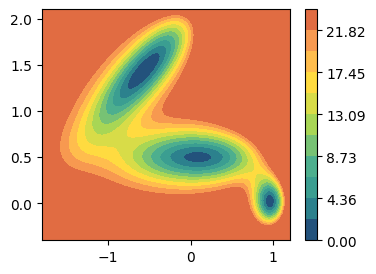

In [3]:
fig, ax = plt.subplots(figsize=(4,3))
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax)
MULLER_BROWN_FORMULA='0.15*(146.7-280*exp(-15*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-170*exp(-1*(x-0.2)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

## MultiTask CV: AutoEncoder + TDA loss

In [4]:
from mlcolvar.cvs import MultiTaskCV
from mlcolvar.cvs import AutoEncoderCV
from mlcolvar.core.loss import TDALoss


RESULTS_FOLDER = 'results/multitask'
# subprocess.run(f"rm -r {RESULTS_FOLDER}", shell=True)
# subprocess.run(f"mkdir {RESULTS_FOLDER}", shell=True)

### Load data: unsupervised + supervised

In [5]:
n_states = 3

# load unlabeled data
filenames = [ f"results/supervised/data/COLVAR"]
unsupervised_dataset, unsupervised_df = create_dataset_from_files(filenames, return_dataframe=True, filter_args={'regex':'p.x|p.y'}, verbose=False, start=0, stop=6000, create_labels=False)

# load labeled data
filenames = [ f"input_data/supervised/state-{i}/COLVAR" for i in range(n_states) ]
supervised_dataset, supervised_df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'}, start=0, stop=2000, verbose=False)

# create multitask datamodule with both datasets
datamodule = DictModule(dataset=[unsupervised_dataset, supervised_dataset])
datamodule

DictModule(dataset -> [DictDataset( "data": [6000, 2] ), DictDataset( "data": [6000, 2], "labels": [6000] )],
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

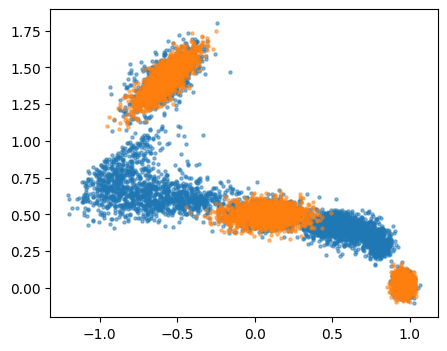

In [6]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(unsupervised_df['p.x'], unsupervised_df['p.y'], s=5, alpha=0.5)
ax.scatter(supervised_df['p.x'], supervised_df['p.y'], s=5, alpha=0.5)


### Define model

In [7]:
n_descriptors = 2
n_components = 1

nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }
if run_calculations:
    main_cv = AutoEncoderCV(encoder_layers=[n_descriptors, 32, 16, n_components], options=options)

    aux_loss_fn = TDALoss(n_states, [-5, 0, 5], [0.2, 0.2, 0.2])

    model = MultiTaskCV(main_cv, auxiliary_loss_fns=[aux_loss_fn], loss_coefficients=[1.5])
    stat = Statistics()
    stat(unsupervised_dataset['data'])
    stat(supervised_dataset['data']) 
    model.norm_in.set_from_stats(stat)
else: 
    model = torch.jit.load(f'{RESULTS_FOLDER}/model_multitask.pt')

### Define trainer and fit

In [8]:
if run_calculations:
    # define callbacks
    metrics = MetricsCallback()
    early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-4, patience=50000)
    # define trainer
    trainer = pl.Trainer(accelerator='cuda',callbacks=[metrics], max_epochs=500,
                        enable_checkpointing=False, enable_model_summary=False)
    # fit
    trainer.fit( model, datamodule )
    traced_model = model.to_torchscript(file_path=f'{RESULTS_FOLDER}/model_multitask.pt', method='trace')

In [9]:
if run_calculations:
    metrics.metrics.keys()  
    plot_metrics(metrics.metrics, ['train_loss', 'train_aux_loss_0', 'train_total_loss_epoch'])

### Analysis of the CV

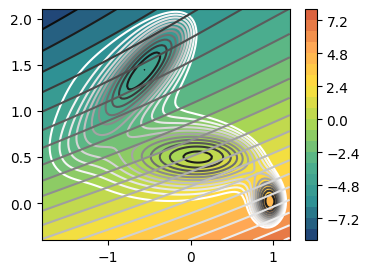

In [10]:
fig,axs = plt.subplots( 1, n_components, figsize=(4*n_components,3) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=25, ax=ax)
    plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

#plt.savefig(f'{RESULTS_FOLDER}/cv_isolines.png')
plt.show()

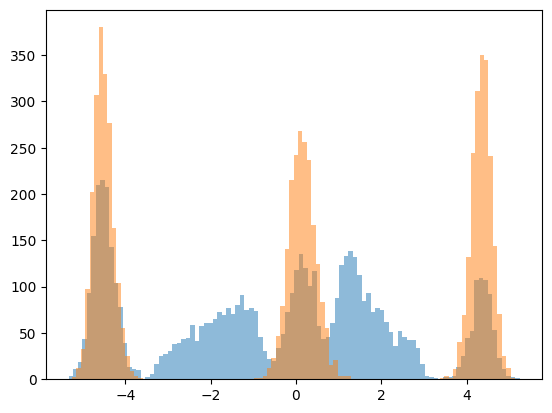

In [11]:
with torch.no_grad():
    plt.hist(model(unsupervised_dataset['data']).numpy(),bins=100, alpha=0.5)
    plt.hist(model(supervised_dataset['data']).numpy(),bins=100, alpha=0.5)


## Run PLUMED simulation

In [12]:
SIMULATION_FOLDER = f'{RESULTS_FOLDER}/data'

if run_calculations:
        # create folder
        subprocess.run(f"mkdir {SIMULATION_FOLDER}", shell=True)

        # generate inputs
        gen_plumed(model_name=f'model_multitask.pt', 
                file_path=SIMULATION_FOLDER, 
                potential_formula=MULLER_BROWN_FORMULA, 
                opes_mode='OPES_METAD')
        gen_input_md(inital_position='-0.7,1.4', file_path=SIMULATION_FOLDER, nsteps=1000000)
        gen_input_md_potential(file_path=SIMULATION_FOLDER)

        subprocess.run(f'{PLUMED_EXE} ves_md_linearexpansion < input_md.dat', cwd=SIMULATION_FOLDER, shell=True, executable='/bin/bash')

### VIsualize sampling

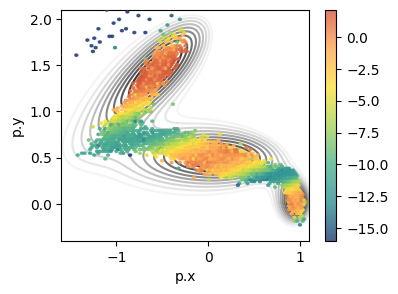

In [13]:
data = load_dataframe(f'{SIMULATION_FOLDER}/COLVAR')
fig, ax = plt.subplots(figsize=(4,3))
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax, mode='contour', zorder=0)
data.plot.hexbin('p.x', 'p.y', C='opes.bias',cmap='fessa', ax=ax,zorder=5, alpha=0.8)
ax.set_xlim(-1.6,1.1)
ax.set_ylim(-0.4,2.1)
#plt.savefig(f'{SIMULATION_FOLDER}/sampling.png')
plt.show()

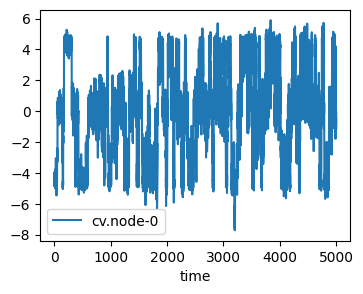

In [14]:
fig, ax = plt.subplots(figsize=(4,3))
data.plot('time', 'cv.node-0', ax=ax)
plt.show()

## Generative mode

In [16]:
samples = torch.linspace(-5.5,5.5, 100).unsqueeze(-1)

# export model decoder
if run_calculations:
    class NormalizationInverse( Normalization):
        def forward(self,x):
            return self.inverse(x)
            
    inv_norm = NormalizationInverse(in_features=2)
    inv_norm.set_custom(mean=model.norm_in.mean, range=model.norm_in.range)

    decoder = torch.nn.Sequential(*[model.decoder, inv_norm])
    traced_decoder = torch.jit.trace(decoder,  example_inputs=samples[0])
    torch.jit.save(traced_decoder, f'{RESULTS_FOLDER}/decoder_model.pt')
else:
    decoder = torch.jit.load(f'{RESULTS_FOLDER}/decoder_model.pt')

gen = decoder(samples)

## Analysis

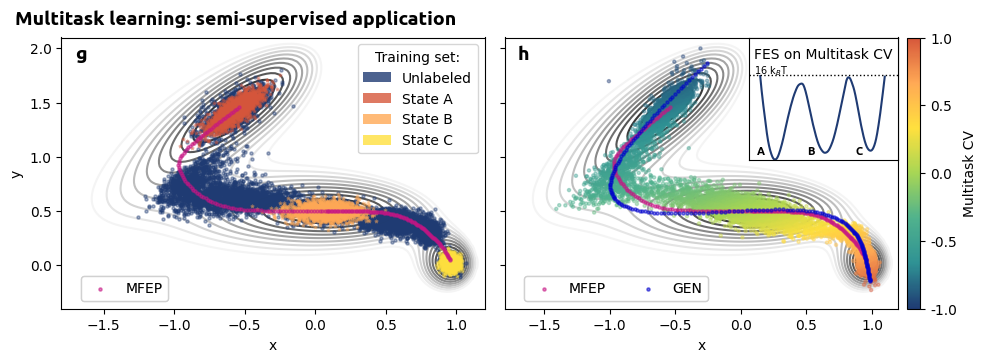

In [19]:
# load MFEP reference
mfep= np.loadtxt('input_data/multitask/mfep.txt',usecols=(0,1))

# create synthetic samples in CV space
samples = torch.linspace(-5.5,5.5, 200).unsqueeze(-1)

# generate synthetic configurations
gen_conf = decoder(samples)

# create figure
fig, axs = plt.subplots(1, 2, figsize=(10,3.5))

# panel g
ax = axs[0]

# load supervised dataframe
supervised_df = pd.DataFrame()
for i in range(0,3):
    temp = load_dataframe(f'input_data/supervised/state-{i}/COLVAR')
    temp['labels'] = i
    supervised_df = pd.concat((supervised_df, temp), ignore_index=True)

# load unsupervised dataframe
unsupervised_df = load_dataframe('results/supervised/data/COLVAR')

# plot data
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax, mode='contour', zorder=0)
unsupervised_df.plot.scatter('p.x', 'p.y', c=paletteFessa[0], ax=ax,zorder=5, alpha=0.4, s=5, colorbar=False)
for i in range(3):
    data_red = supervised_df.iloc[(supervised_df['labels'] == i).values]
    cp = ax.scatter(data_red['p.x'],data_red['p.y'],c=paletteFessa[(-1-i)], marker='*', zorder=5, alpha=0.4, s=5)
ref = ax.scatter(mfep[:, 0], mfep[:, 1], s=5, zorder=10, c='mediumvioletred', alpha=0.5, label='Ref MFEP', marker='o')

# visible legend 
proxy = [plt.Rectangle((0,0),1,1,fc = paletteFessa[0], alpha=0.8),
         plt.Rectangle((0,0),1,1,fc = paletteFessa[-1], alpha=0.8), 
         plt.Rectangle((0,0),1,1,fc = paletteFessa[-2], alpha=0.8), 
         plt.Rectangle((0,0),1,1,fc = paletteFessa[-3], alpha=0.8) ]
ax.legend(proxy, ["Unlabeled", "State A", "State B", "State C"], title='Training set:', prop={'size': 10})

plot_lines = [ref]
legend2 = fig.legend(plot_lines, ["MFEP"], ncol=2,bbox_to_anchor=(-0.32, -0.22, 0.5, 0.5))
ax.add_artist(legend2)

# labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-1.8, 1.2)
ax.set_ylim(-0.4, 2.1)



# panle h
ax = axs[1]

# load data
data = load_dataframe('results/multitask/data/COLVAR')

# filter nonsense-bias points 
data = data [data['opes.bias'] > -14]
c = data['cv.node-0'].values / 6

# plot data
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax, mode='contour', zorder=0)
data.plot.scatter('p.x', 'p.y', c=c,cmap='fessa', ax=ax,zorder=5, alpha=0.4, s=5, colorbar=False)
ref = ax.scatter(mfep[:, 0], mfep[:, 1], s=5, zorder=10, c='mediumvioletred', alpha=0.5, label='MFEP')
gen = ax.scatter(gen_conf.detach().numpy()[:,0], gen_conf.detach().numpy()[:, 1], s=5, zorder=10, c='mediumblue', alpha=0.5, label='GEN')

# make visible colormap
norm = mlp.colors.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(norm=norm,cmap='fessa')
cbar = plt.colorbar(mappable=sm, fraction=0.050, pad=0.02, format='%.1f', ax = ax, ticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
cbar.set_label('Multitask CV',fontsize=10)

# labels
ax.set_xlim(-1.8, 1.2)
ax.set_ylim(-0.4, 2.1)
ax.yaxis.set_ticklabels([])
ax.set_ylabel(None)
ax.set_xlabel('x')
# ax.legend(loc='lower left', ncol=2)

plot_lines = [ref, gen]
legend = fig.legend(plot_lines, ["MFEP", "GEN"], bbox_to_anchor=(0.22, -0.22, 0.5, 0.5), ncol=2)
ax.add_artist(legend)

# fes inset
fes,bins,_,_ = compute_fes(data['cv.node-0'].values, kbt=1, plot=False, num_samples=1000, scale_by='range', weights=np.exp(data['opes.bias'].values))
fes[fes>15.8] = None
ins = ax.inset_axes([0.62,0.55,0.38,0.45])
cp = ins.plot(bins/10,fes,color=paletteFessa[0],lw=1.5)
ins.hlines(16,-0.8,0.8, ls='dotted', lw=1, color='k')
ins.text(-0.65, 16.2, '16 k$_B$T', fontsize=7)#, font='ubuntu')
ins.yaxis.set_ticklabels([])
ins.yaxis.set_ticks([])
ins.xaxis.set_ticklabels([])
ins.xaxis.set_ticks([])
ins.set_ylim(0,23)
ins.set_xlim(-0.7,0.7)
ins.text(-0.65, 19, 'FES on Multitask CV', fontsize=10, fontweight='medium')

# label states
ins.text(-0.62, 1, 'A', fontsize=8, fontweight='demi', font='ubuntu')
ins.text(-0.15, 1, 'B', fontsize=8, fontweight='demi', font='ubuntu')
ins.text(0.3, 1, 'C', fontsize=8, fontweight='demi', font='ubuntu')

fig.text(0.02, 0.98, 'Multitask learning: semi-supervised application', fontsize=14, fontweight='demi', font='ubuntu')
axs[0].text(-1.7, 1.9, 'g', fontsize=14, fontweight='demi', font='ubuntu')
axs[1].text(-1.7, 1.9, 'h', fontsize=14, fontweight='demi', font='ubuntu')

plt.tight_layout()
# plt.savefig('muller_experiments/figures/examples_multitask_AETDA.png', dpi=200, bbox_inches='tight')
plt.show()

## Extra: additional statistics on generated path

In [ ]:
if run_calculations:
    for i in range(9):
        # define model
        main_cv = AutoEncoderCV(encoder_layers=[n_descriptors, 32, 16, n_components], options=options)
        aux_loss_fn = TDALoss(n_states, [-5, 0, 5], [0.2, 0.2, 0.2])
        model = MultiTaskCV(main_cv, auxiliary_loss_fns=[aux_loss_fn], loss_coefficients=[1.5])
        stat = Statistics()
        stat(unsupervised_dataset['data'])
        stat(supervised_dataset['data']) 
        model.norm_in.set_from_stats(stat)

        # train
        trainer = pl.Trainer(accelerator='cuda', max_epochs=500,
                            enable_checkpointing=False, enable_model_summary=False)
        # fit
        trainer.fit( model, datamodule )
        traced_model = model.to_torchscript(file_path=f'{RESULTS_FOLDER}/decoder_stats/model_multitask_{i}.pt', method='trace')

        inv_norm = NormalizationInverse(in_features=2)
        inv_norm.set_custom(mean=model.norm_in.mean, range=model.norm_in.range)
        test = torch.nn.Sequential(*[model.decoder, inv_norm])
        traced_test = torch.jit.trace(test,  example_inputs=samples[0])
        torch.jit.save(traced_test, f'{RESULTS_FOLDER}/decoder_stats/decoder_model_{i}.pt')


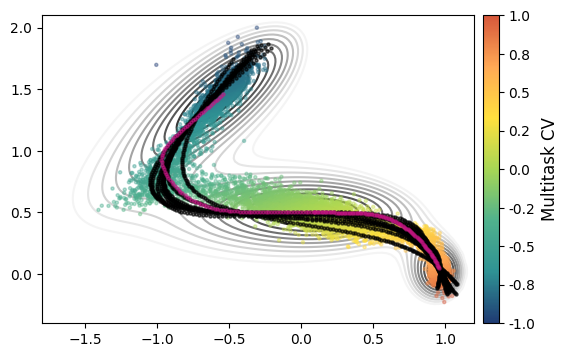

In [20]:
fig, ax = plt.subplots(figsize=(6,4))

data = load_dataframe('results/multitask/data/COLVAR')

plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax, mode='contour', zorder=0)
data = data [data['opes.bias'] > -14]
c = data['cv.node-0'].values / 6
data.plot.scatter('p.x', 'p.y', c=c,cmap='fessa', ax=ax,zorder=5, alpha=0.4, s=5, colorbar=False)

norm = mlp.colors.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(norm=norm,cmap='fessa')
cbar = plt.colorbar(mappable=sm, fraction=0.050, pad=0.02, format='%.1f', ax = ax)#, ax=axs.ravel().tolist())

cbar.set_label('Multitask CV',fontsize=12)


ax.set_xlim(-1.8, 1.2)
ax.set_ylim(-0.4, 2.1)
# ax.yaxis.set_ticklabels([])
# ax.xaxis.set_ticklabels([])

ax.set_ylabel(None)
ax.set_xlabel(None)

for i in range(9):
    conf_generator = torch.jit.load(f'results/multitask/decoder_stats/decoder_model_{i}.pt')
    gen_conf = conf_generator(samples)
    plt.scatter(gen_conf.detach().numpy()[:,0], gen_conf.detach().numpy()[:, 1], s=5, zorder=10, c='k', alpha=0.6)
mfep= np.loadtxt('input_data/multitask/mfep.txt',usecols=(0,1))
ref = ax.scatter(mfep[:, 0], mfep[:, 1], s=5, zorder=10, c='mediumvioletred', alpha=0.5, label='MFEP')

plt.show()